In [183]:
from bs4 import BeautifulSoup 
import requests 
import re
from scipy.integrate import odeint, solve_ivp
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.optimize import curve_fit 

# Get the data
Url's of interesting countries, in our scenarion it will be Poland, Malysia and Belgium.

In [184]:
bg = 'https://www.worldometers.info/coronavirus/country/belgium/'
mal = 'https://www.worldometers.info/coronavirus/country/malaysia/'
pl = 'https://www.worldometers.info/coronavirus/country/poland/'

1. Get the content of page

2. Use regexp to get this kind of data: <br>
&emsp; name: 'Recovery Rate',<br>
&emsp; color: '#8ACA2B',<br>
&emsp; lineWidth: 5,<br>
&emsp; data: [ numbers ]

3. Split names and data

4. Make data more userfirendly - to floats and then to np.array

5. Names of each array

6. Get dates

In [326]:
def get_data(url):
    #1
    page = requests.get(url) 
    #2
    names = re.findall(r'series: \[\{\s*name: \'([a-zA-Z\s ]*)\'[a-zA-Z\#0-9\s\n\,\.\'\:\- ]*data: \[([0-9\,\s\.null\- ]*)\]', page.text)
    #3
    datas = [n[1] for n in names]
    names = [n[0] for n in names]
    #4
    datas = [d.split(',') for d in datas]
    datas = [[ 0 if d == 'null' else float(d) for d in data] for data in datas]
    datas = np.nan_to_num(datas,0)
    datas = np.array(datas)
    datas[datas<0]=0
    print('datas shape:',datas.shape)
    #5
    for i, n in enumerate(names):
        print(i,n)
    #6
    dates = re.findall(r'categories: \[([\"A-Za-z\s0-9\, ]*)\]\n', page.text)
    if len(dates) > 0: dates = dates[0].replace('"','').split(',')
    
    return names, datas, dates

### Fit exp or gauss to existing data

In [186]:
def my_exp(x, a, b=0): 
    if type(a) is np.ndarray:
        a, b = a
    return a*np.exp(b*x) 
    
def my_gauss(x, a, mu=0, sigma=0):
    if type(a) is np.ndarray:
        a, mu, sigma = a
    return a*np.exp(-(x-mu)**2/(2*sigma**2))

def my_sigmoid(x, a, b=0, c=0):
    if type(a) is np.ndarray:
        a, b, c = a
    return c / (1.0 + np.exp(-a*(x-b)))

#param, param_cov = curve_fit(my_exp, x, y) 

# Real data

## Poland overwiev

## Poland
Koronawirus COVID-19. Czwarty etap znoszenia ograniczeń [30.05.2020] <br>
Zniesienie obowiązku zasłaniania ust i nosa w przestrzeni otwartej [30.05.2020] <br>
Koronawirus COVID-19. Trzeci etap znoszenia ograniczeń [18.05.2020] <br>
Koronawirus COVID-19. Drugi etap znoszenia ograniczeń [04.05.2020] <br>
Koronawirus COVID-19. Pierwszy etap znoszenia ograniczeń [20.04.2020] <br>
Obowiązek zasłaniania ust i nosa [16.04.2020] <br>
Ograniczenia na Wielkanoc [09.04.2020] <br>
Wprowadzenie kolejnych ograniczeń i zakazów w Polsce [31.03.2020] <br>
Nowe restrykcje i ograniczenia wprowadzone w Polsce [24.03.2020] <br>
Stan zagrożenia epidemicznego w Polsce – jakie ograniczenia wprowadzono? [16.03.2020] <br> 
https://www.medonet.pl/koronawirus-pytania-i-odpowiedzi/sars-cov-2,koronawirus---obostrzenia-w-polsce--etapy-znoszenia-ograniczen--aktualne-dane-,artykul,98382723.html

In [187]:
names, datas, dates = get_data(pl)

datas shape: (11, 115)
0 Currently Infected
1 Death Rate
2 Cases
3 Cases
4 Daily Cases
5 Currently Infected
6 Deaths
7 Deaths
8 Daily Deaths
9 New Recoveries
10 Death Rate


In [188]:
Idaily = datas[4]
Ddaily = datas[-3]
Rdaily = datas[-2]

Itotal = datas[0]
Dtotal = datas[-4]
Rtotal = np.cumsum(Rdaily)

In [189]:
#restrictions
r0 = dates.index('Mar 16')
r1 = dates.index('Mar 24')
r2 = dates.index('Mar 31')
#freedoms
f0 = dates.index('Apr 20')
f1 = dates.index('May 04')
f2 = dates.index('May 18')
f3 = dates.index('May 30')

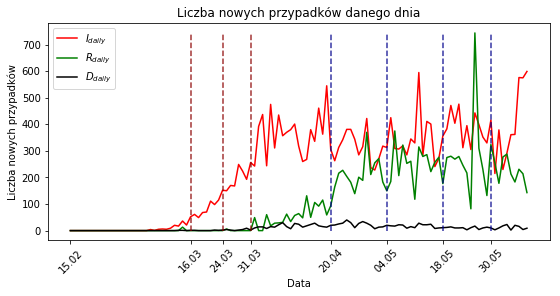

In [190]:
plt.figure(figsize=(9,4))
plt.plot(Idaily, 'r', label=r'$I_{daily}$')
plt.plot(Rdaily, 'g', label=r'$R_{daily}$')
plt.plot(Ddaily, 'k', label=r'$D_{daily}$')

mx = np.ceil(np.max(Rdaily))
plt.plot([r0,r0],[0,mx], '--', c='darkred', alpha=0.8)
plt.plot([r1,r1],[0,mx], '--', c='darkred', alpha=0.8)
plt.plot([r2,r2],[0,mx], '--', c='darkred', alpha=0.8)
plt.plot([f0,f0],[0,mx], '--', c='darkblue', alpha=0.8)
plt.plot([f1,f1],[0,mx], '--', c='darkblue', alpha=0.8)
plt.plot([f2,f2],[0,mx], '--', c='darkblue', alpha=0.8)
plt.plot([f3,f3],[0,mx], '--', c='darkblue', alpha=0.8)

my_xticks = ['15.02','16.03','24.03','31.03','20.04','04.05','18.05','30.05']
x = [0,r0,r1,r2,f0,f1,f2,f3]
plt.xticks(x, my_xticks, rotation=45)

plt.title('Liczba nowych przypadków danego dnia')
plt.xlabel('Data')
plt.ylabel('Liczba nowych przypadków')
plt.legend()
plt.savefig('images/poland.png', bbox_inches='tight')

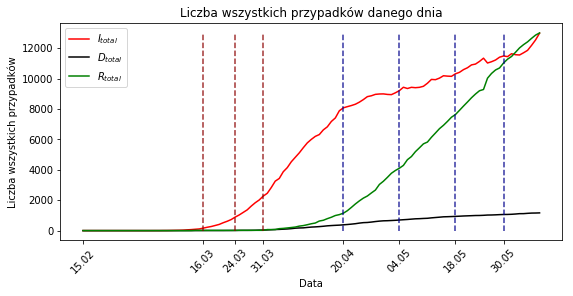

In [191]:
plt.figure(figsize=(9,4))
#np.cumsum(Idaily)-Dtotal-Rtotal
plt.plot(Itotal,'r', label=r'$I_{total}$')
plt.plot(Dtotal, 'k', label=r'$D_{total}$')
plt.plot(Rtotal, 'g', label=r'$R_{total}$')

mx = np.ceil(np.max(Itotal))
plt.plot([r0,r0],[0,mx], '--', c='darkred', alpha=0.8)
plt.plot([r1,r1],[0,mx], '--', c='darkred', alpha=0.8)
plt.plot([r2,r2],[0,mx], '--', c='darkred', alpha=0.8)
plt.plot([f0,f0],[0,mx], '--', c='darkblue', alpha=0.8)
plt.plot([f1,f1],[0,mx], '--', c='darkblue', alpha=0.8)
plt.plot([f2,f2],[0,mx], '--', c='darkblue', alpha=0.8)
plt.plot([f3,f3],[0,mx], '--', c='darkblue', alpha=0.8)

my_xticks = ['15.02','16.03','24.03','31.03','20.04','04.05','18.05','30.05']
x = [0,r0,r1,r2,f0,f1,f2,f3]
plt.xticks(x, my_xticks, rotation=45)

plt.title('Liczba wszystkich przypadków danego dnia')
plt.xlabel('Data')
plt.ylabel('Liczba wszystkich przypadków')
plt.legend()
plt.savefig('images/poland_total.png', bbox_inches='tight')

## Poland
### 1st period 

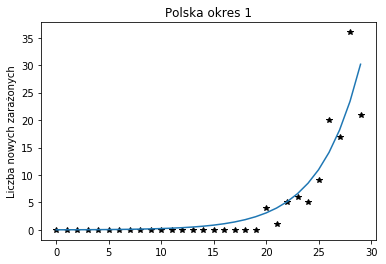

In [225]:
y = Idaily[:r0]
x = np.arange(0,r0)

pe, param_cov_e = curve_fit(my_exp, x, y) 
#pg, param_cov_g = curve_fit(my_gauss, x, y, p0=p0)

plt.plot(x,y,'k*')
plt.plot(x,my_exp(x,pe))
#plt.plot(x,my_gauss(x,pg))

plt.title('Polska okres 1')
plt.ylabel('Liczba nowych zarażonych')
plt.savefig('images/poland_1.png', bbox_inches='tight')
dI1=int(my_exp(x[-1],pe))

### 2st period 

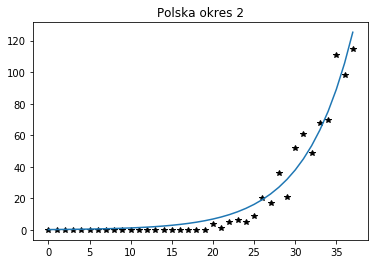

In [230]:
y = Idaily[r0:r1]
x = np.arange(0,r1-r0)
y1 = Idaily[0:r1]
x1 = np.arange(0,r1)

#p0 = [1, 4000, 3000]
pe, param_cov_e = curve_fit(my_exp, x, y) 
pe1, param_cov_e = curve_fit(my_exp, x1, y1) 
#pg, param_cov_g = curve_fit(my_gauss, x, y, p0=p0)

plt.plot(x1,y1,'k*')
plt.plot(x1,my_exp(x1,pe1))

#plt.plot(x,my_gauss(x,pg))

plt.title('Polska okres 2')
plt.ylabel('')
plt.savefig('images/poland_2.png', bbox_inches='tight')
dI2=int(my_exp(x[-1],pe))

### 3rd period 

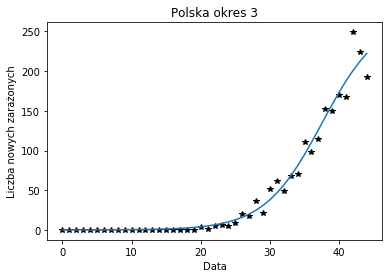

In [240]:
y = Idaily[0:r2]
x = np.arange(0,r2)

ps0=[0.15,45,500]
pg0=[500, 2000, 300]
pe, param_cov_e = curve_fit(my_exp, x, y) 
#pg, param_cov_g = curve_fit(my_gauss, x, y, p0=pg0, maxfev=2000)
ps, param_cov_g = curve_fit(my_sigmoid, x, y, p0=ps0)

plt.plot(x,y,'k*')
#plt.plot(x,my_exp(x,pe))
#plt.plot(x,my_gauss(x,pg))
plt.plot(x,my_sigmoid(x,ps))

plt.title('Polska okres 3')
plt.xlabel('Data')
plt.ylabel('Liczba nowych zarażonych')
plt.savefig('images/poland_3.png', bbox_inches='tight')
dI3=int(my_sigmoid(x[-1],ps))

### 4th period 

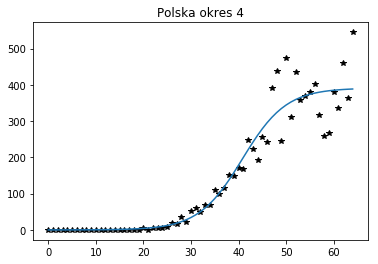

In [176]:
y = Idaily[0:f0]
x = np.arange(0,f0)

ps0=[0.15,45,500]
pg0=[500, 2000, 300]
pe, param_cov_e = curve_fit(my_exp, x, y) 
#pg, param_cov_g = curve_fit(my_gauss, x, y, p0=pg0, maxfev=2000)
ps, param_cov_g = curve_fit(my_sigmoid, x, y, p0=ps0)

plt.plot(x,y,'k*')
#plt.plot(x,my_exp(x,pe))
#plt.plot(x,my_gauss(x,pg))
plt.plot(x,my_sigmoid(x,ps))

plt.title('Polska okres 4')
plt.show()

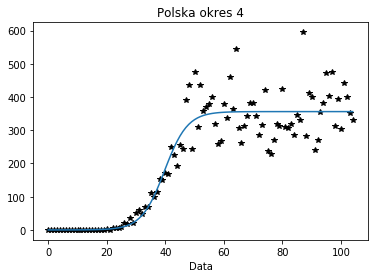

In [239]:
y = Idaily[0:f3]
x = np.arange(0,f3)

ps0=[0.15,45,500]
pg0=[500, 2000, 300]
pe, param_cov_e = curve_fit(my_exp, x, y) 
#pg, param_cov_g = curve_fit(my_gauss, x, y, p0=pg0, maxfev=2000)
ps, param_cov_g = curve_fit(my_sigmoid, x, y, p0=ps0)

plt.plot(x,y,'k*')
#plt.plot(x,my_exp(x,pe))
#plt.plot(x,my_gauss(x,pg))
plt.plot(x,my_sigmoid(x,ps))

plt.title('Polska okres 4')
plt.xlabel('Data')
plt.ylabel('')
plt.savefig('images/poland_4.png', bbox_inches='tight')
dI4=int(my_sigmoid(x[-1],ps))

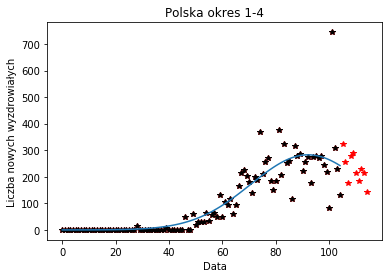

In [237]:
y = Rdaily[:f3]
x = np.arange(0,f3)

pe, param_cov_e = curve_fit(my_exp, x, y) 
pg, param_cov_g = curve_fit(my_gauss, x, y, p0=p0)
ps, param_cov_g = curve_fit(my_sigmoid, x, y, p0=ps0)

plt.plot(Rdaily,'r*')
plt.plot(x,y,'k*')
#plt.plot(x,my_exp(x,pe))
plt.plot(x,my_gauss(x,pg))
#plt.plot(x,my_sigmoid(x,ps))

plt.title('Polska okres 1-4')
plt.xlabel('Data')
plt.ylabel('Liczba nowych wyzdrowiałych')
plt.savefig('images/poland_R.png', bbox_inches='tight')
dR1=int(my_gauss(x[r0],pg))
dR2=int(my_gauss(x[r1],pg))
dR3=int(my_gauss(x[r2],pg))
dR4=int(my_gauss(x[-1],pg))

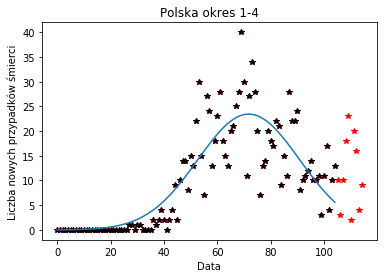

In [236]:
y = Ddaily[:f3]
x = np.arange(0,f3)

pe, param_cov_e = curve_fit(my_exp, x, y) 
pg, param_cov_g = curve_fit(my_gauss, x, y, p0=p0)
ps, param_cov_g = curve_fit(my_sigmoid, x, y, p0=ps0)

plt.plot(Ddaily,'r*')
plt.plot(x,y,'k*')
#plt.plot(x,my_exp(x,pe))
plt.plot(x,my_gauss(x,pg))
#plt.plot(x,my_sigmoid(x,ps))

plt.title('Polska okres 1-4')
plt.xlabel('Data')
plt.ylabel('Liczba nowych przypadków śmierci')
plt.savefig('images/poland_D.png', bbox_inches='tight')
dD1=int(my_gauss(x[r0],pg))
dD2=int(my_gauss(x[r1],pg))
dD3=int(my_gauss(x[r2],pg))
dD4=int(my_gauss(x[-1],pg))

### Computed Values

In [241]:
print(dI1,dI2,dI3,dI4)
print(dR1,dR2,dR3,dR4)
print(dD1,dD2,dD3,dD4)

30 116 222 356
4 11 25 242
2 4 8 5


In [245]:
print(Itotal[[r0,r1,r2,f3]])
print(Rtotal[[r0,r1,r2,f3]])
print(Dtotal[[r0,r1,r2,f3]])

[  160.   890.  2271. 11494.]
[   13.    13.    19. 11028.]
[   4.   10.   33. 1061.]


### Calculation od model

Iitialize parameters

In [292]:
# Total population, N.
N = 37 * 10**6

Function to count derivatives <br>
credit: https://scipython.com/book/chapter-8-scipy/additional-examples/the-sir-epidemic-model/

In [293]:
# The SIR model differential equations.
def deriv(y, t, N, beta, gamma, delta):
    S, I, R, D = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I - delta * I
    dRdt = gamma * I
    dDdt = delta * I
    return dSdt, dIdt, dRdt, dDdt

Run model

In [307]:
def plot_SIR(I0,R0,D0, dI,dR,dD, tit,t_max=200):
    # Initial number of infected and recovered individuals, I0, R0, D0.
    # Everyone else, S0, is susceptible to infection initially.
    S0 = N - I0 - R0 - D0
    # parameters
    gamma = dR/I0
    delta = dD/I0
    beta = (dI + (gamma-delta)*I0)*N/(S0*I0)
    print('beta =',beta)
    print('gamma =',gamma)
    print('delta =',delta)
    
    # A grid of time points (in days)
    t = np.linspace(0, t_max, t_max)
    
    # Initial conditions vector
    y0 = S0, I0, R0, D0
    # Integrate the SIR equations over the time grid, t.
    ret = odeint(deriv, y0, t, args=(N, beta, gamma, delta))
    S, I, R, D = ret.T
    
    # Plot the data on three separate curves for S(t), I(t) and R(t)
    fig = plt.figure()
    plt.plot(t, S/1000, 'b', alpha=0.5, lw=2, label='S')
    plt.plot(t, I/1000, 'r', alpha=0.5, lw=2, label='I')
    plt.plot(t, R/1000, 'g', alpha=0.5, lw=2, label='R')
    plt.plot(t, D/1000, 'k', alpha=0.5, lw=2, label='D')
    
    plt.xlabel('Dzień')
    plt.ylabel('Liczba przypadków (tysiące)')
    legend = plt.legend()
    legend.get_frame().set_alpha(0.5)
    plt.title(tit)    
    return S, I, R, D

Plotting results

beta = 0.2000009567613337
gamma = 0.025
delta = 0.0125
beta = 0.13820565750899247
gamma = 0.012359550561797753
delta = 0.0044943820224719105
beta = 0.10524659016577477
gamma = 0.011008366358432409
delta = 0.0035226772346983706
beta = 0.05162503971106535
gamma = 0.02105446319819036
delta = 0.0004350095702105446


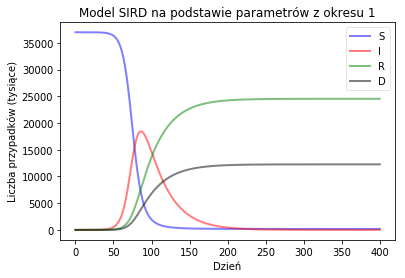

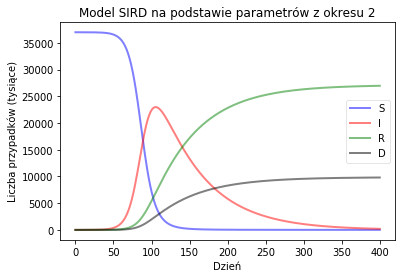

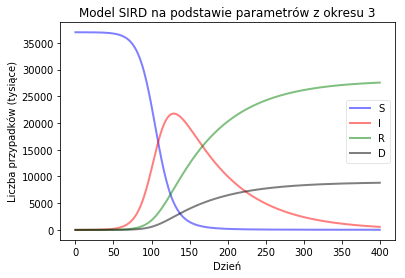

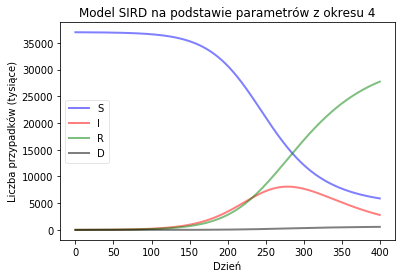

In [345]:
Itab = []
for i, nt in enumerate([r0,r1,r2,f3]):
    dValuse = [[dI1,dR1,dD1],
              [dI2,dR2,dD2],
              [dI3,dR3,dD3],
              [dI4,dR4,dD4]]
    S, I, R, D  = plot_SIR(Itotal[nt],Rtotal[nt],Dtotal[nt], 
                           dValuse[i][0],dValuse[i][1],dValuse[i][2],
                           tit='Model SIRD na podstawie parametrów z okresu '+str(i+1),
                           t_max=400)
    Itab.append(I)
    
    plt.savefig('images/poland_SIRD'+str(i+1)+'.png', bbox_inches='tight')

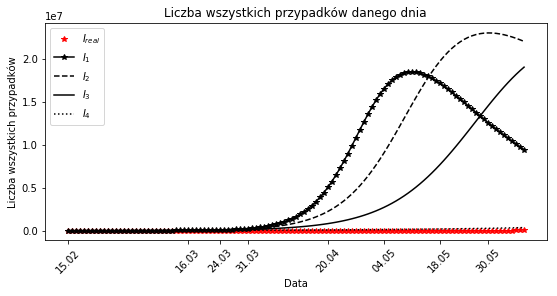

In [351]:
plt.figure(figsize=(9,4))
#np.cumsum(Idaily)-Dtotal-Rtotal
plt.plot(Itotal,'r*', label=r'$I_{real}$')
plt.plot(Itab[0][:len(Itotal)],'k-*', label=r'$I_{1}$')
plt.plot(Itab[1][:len(Itotal)],'k--', label=r'$I_{2}$')
plt.plot(Itab[2][:len(Itotal)],'k-', label=r'$I_{3}$')
plt.plot(Itab[3][:len(Itotal)],'k:', label=r'$I_{4}$')

my_xticks = ['15.02','16.03','24.03','31.03','20.04','04.05','18.05','30.05']
x = [0,r0,r1,r2,f0,f1,f2,f3]
plt.xticks(x, my_xticks, rotation=45)

plt.title('Liczba wszystkich przypadków danego dnia')
plt.xlabel('Data')
plt.ylabel('Liczba wszystkich przypadków')
plt.legend()
plt.savefig('images/poland_compare.png', bbox_inches='tight')

# SIR model

In [615]:
# The SIR model differential equations.
def deriv2(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

In [647]:
def SIR(I0,R0,N, dI,dR, tit,t_max=200, dt=50):
    # Initial number of infected and recovered individuals, I0, R0, D0.
    # Everyone else, S0, is susceptible to infection initially.
    S0 = N - I0 - R0 
    # parameters
    gamma = dR/I0
    beta = (dI + gamma*I0)*N/(S0*I0)
    print('beta =',beta)
    print('gamma =',gamma)
    
    # A grid of time points (in days)
    t = np.linspace(0, t_max, t_max)
    
    # Initial conditions vector
    y0 = S0, I0, R0
    # Integrate the SIR equations over the time grid, t.
    ret = odeint(deriv2, y0, t, args=(N, beta, gamma))
    S, I, R = ret.T
    
    # Plot the data on three separate curves for S(t), I(t) and R(t)
    fig = plt.figure()
    plt.plot(t+dt, S/1000, 'b', alpha=0.5, lw=2, label='S')
    plt.plot(t+dt, I/1000, 'r', alpha=0.5, lw=2, label='I')
    plt.plot(t+dt, R/1000, 'g', alpha=0.5, lw=2, label='R')
    
    plt.xlabel('Dzień')
    plt.ylabel('Liczba przypadków (tysiące)')
    legend = plt.legend()
    legend.get_frame().set_alpha(0.5)
    plt.title(tit)    

## Malaysia

In [704]:
names, datas, dates = get_data(mal)

datas shape: (7, 115)
0 Cases
1 Cases
2 Daily Cases
3 Currently Infected
4 Deaths
5 Deaths
6 Daily Deaths


In [705]:
Itotal = datas[3]
Rtotal = np.cumsum(datas[2]) - datas[3]

Idaily = datas[2]
Rdaily = np.diff(Rtotal)
Rdaily[Rdaily<0] = 0

In [706]:
x = np.arange(0,Idaily.shape[0])

pg, param_cov_g = curve_fit(my_gauss, x, Idaily,p0=[100,60,40])
pg1, param_cov_g = curve_fit(my_gauss, x[:-1], Rdaily, p0=[100,60,40])

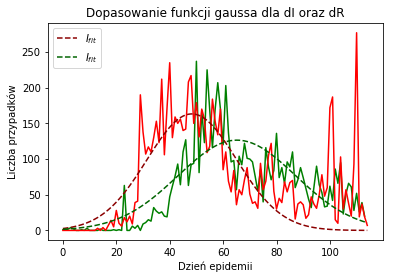

In [740]:
plt.plot(Rdaily,'g')
plt.plot(Idaily,'r')

plt.plot(x,my_gauss(x,pg),'--',c='darkred', label=r'$I_{fit}$')
plt.plot(x,my_gauss(x,pg1),'--',c='darkgreen', label=r'$I_{fit}$')

plt.legend()
plt.title('Dopasowanie funkcji gaussa dla dI oraz dR')
plt.xlabel('Dzień epidemii')
plt.ylabel('Liczba przypadków')

plt.savefig('images/malysian_fit.png', bbox_inches='tight')
day = 50
dR = my_gauss(x,pg1)[day]
dI = my_gauss(x,pg)[day]

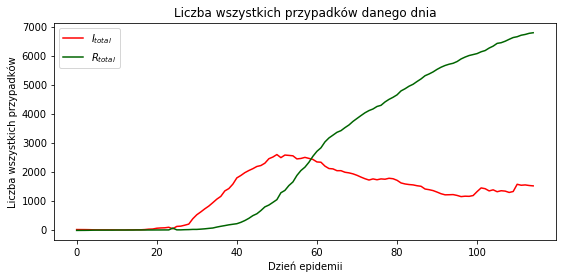

In [741]:
plt.figure(figsize=(9,4))
#np.cumsum(Idaily)-Dtotal-Rtotal
plt.plot(Itotal,'r', label=r'$I_{total}$')
plt.plot(Rtotal, 'darkgreen', label=r'$R_{total}$')

plt.title('Liczba wszystkich przypadków danego dnia')
plt.xlabel('Dzień epidemii')
plt.ylabel('Liczba wszystkich przypadków')
plt.legend()
plt.savefig('images/malysia_total.png', bbox_inches='tight')

In [742]:
N = 31*10**6

beta = 0.10103267859435697
gamma = 0.03845321590523187


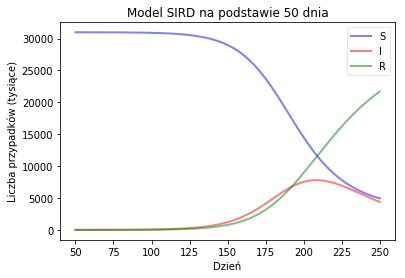

In [743]:
SIR(Itotal[day],Rtotal[day],N, dI,dR,'Model SIRD na podstawie '+str(day)+' dnia', t_max=200, dt=day)
plt.savefig('images/malysia_SIR_'+str(day)+'.png', bbox_inches='tight')

## Belgium

In [744]:
names, datas, dates = get_data(bg)

datas shape: (11, 115)
0 Currently Infected
1 Death Rate
2 Cases
3 Cases
4 Daily Cases
5 Currently Infected
6 Deaths
7 Deaths
8 Daily Deaths
9 New Recoveries
10 Death Rate


In [745]:
Itotal = datas[0]
Rtotal = np.cumsum(datas[9]) + np.cumsum(datas[8])

Idaily = datas[4]
Rdaily = datas[-3] + datas[-2]

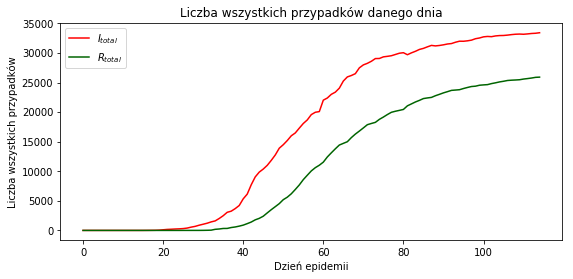

In [746]:
plt.figure(figsize=(9,4))
#np.cumsum(Idaily)-Dtotal-Rtotal
plt.plot(Itotal,'r', label=r'$I_{total}$')
plt.plot(Rtotal, 'darkgreen', label=r'$R_{total}$')

#plt.plot(np.cumsum(datas[9]), 'g', label=r'$R$')
#plt.plot(np.cumsum(datas[8]), 'k', label=r'$D$')

plt.title('Liczba wszystkich przypadków danego dnia')
plt.xlabel('Dzień epidemii')
plt.ylabel('Liczba wszystkich przypadków')
plt.legend()
plt.savefig('images/belgium_total.png', bbox_inches='tight')

In [747]:
def my_gauss2(x, a, mu=0, sigma=0, b=1):
    if type(a) is np.ndarray:
        a, mu, sigma,b = a
    return a*np.exp(-(x-mu)**2/(2*sigma**2)) + b

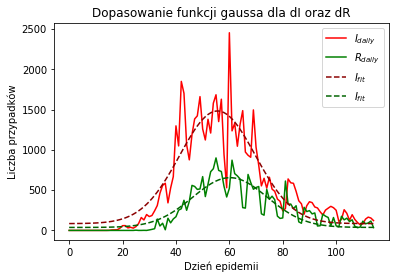

In [754]:
y = Idaily
x = np.arange(0,Rdaily.shape[0])

p0 = [300,100,150,1]
p01 = [100,50,150,1]

pg, param_cov_g = curve_fit(my_gauss2, x, Idaily, p0=p0)
pg1, param_cov_g = curve_fit(my_gauss2, x, Rdaily, p0=p01)


plt.plot(Idaily,'r', label=r'$I_{daily}$')
plt.plot(Rdaily, 'g', label=r'$R_{daily}$')

plt.plot(my_gauss2(x,pg),'--',c='darkred', label=r'$I_{fit}$')
plt.plot(my_gauss2(x,pg1),'--',c='darkgreen', label=r'$I_{fit}$')

plt.legend()
plt.title('Dopasowanie funkcji gaussa dla dI oraz dR')
plt.xlabel('Dzień epidemii')
plt.ylabel('Liczba przypadków')

plt.savefig('images/belgium_fit.png', bbox_inches='tight')
day = 40
dR = my_gauss2(x,pg1)[day]
dI = my_gauss2(x,pg)[day]

In [755]:
N = 11*10**6

beta = 0.20652671591248492
gamma = 0.04752168275722096


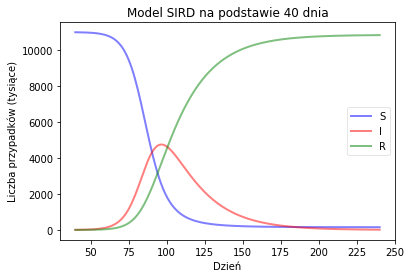

In [756]:
SIR(Itotal[day],Rtotal[day],N, dI,dR,'Model SIRD na podstawie '+str(day)+' dnia', t_max=200, dt=day)
plt.savefig('images/belgium_SIR_'+str(day)+'.png', bbox_inches='tight')